In [79]:
import torch
import torch_geometric

In [23]:
df_true = pd.read_csv("ground_truths.csv", header=0)
df_pred = pd.read_csv("predictions.csv", header=0)

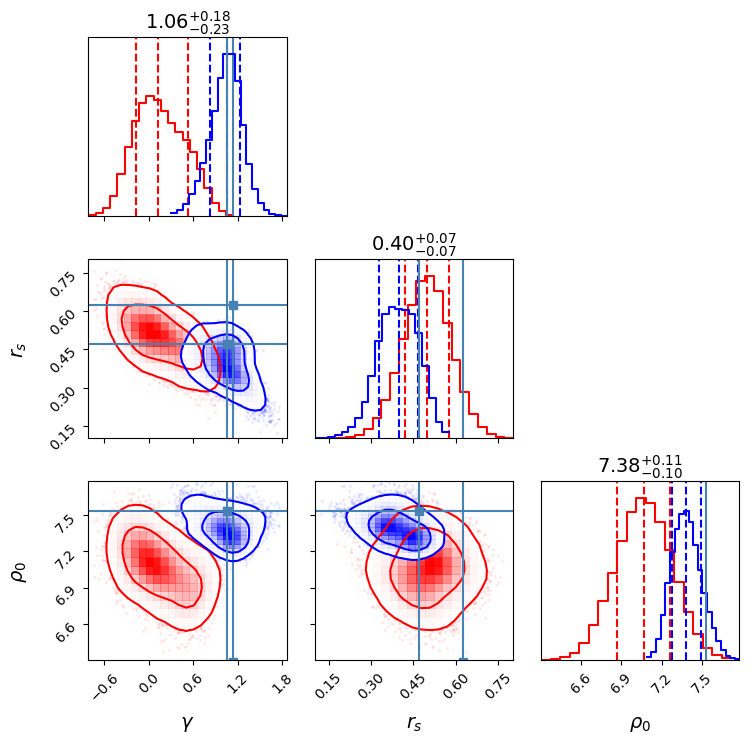

In [19]:
'''

Module to bootstrap posterior samples from a trained GNN model and visualize
results with overlaid corner plots. Documentation is provided without altering
the original code logic or structure.

Steps:
  1) Load pretrained GNN model
  2) Define graph construction helper (make_graph)
  3) Load dataset (StarSamplerGraphDataset)
  4) Define bootstrap_posterior function
  5) Generate posterior samples for specified indices
  6) Load ground-truth values
  7) Configure and create corner plots
  8) Save and display the final figure

Dependencies:
  - torch
  - numpy
  - pandas
  - corner
  - matplotlib.pyplot
  - torch_geometric.data.Data
  - sklearn.neighbors.NearestNeighbors
  - SimpleGCN (StellarGNN, StarSamplerGraphDataset)
'''

import torch
import numpy as np
import pandas as pd
import corner
import matplotlib.pyplot as plt
from torch_geometric.data import Data
from sklearn.neighbors import NearestNeighbors
from SimpleGCN import StellarGNN, StarSamplerGraphDataset

# -----------------------------------------------------------------------------
# 1) Load pretrained GNN model
# -----------------------------------------------------------------------------
# Choose device: GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instantiate model
model  = StellarGNN(input_dim=3, hidden_dim=64, output_dim=5).to(device)
# Load saved weights and set to evaluation mode
state  = torch.load("best_model.pt", map_location=device)
model.load_state_dict(state)
model.eval()

# -----------------------------------------------------------------------------
# 2) Graph construction helper via k-nearest neighbors
# -----------------------------------------------------------------------------
def make_graph(x_np, k=20):
    '''
    Build a PyG Data graph from node features.

    Args:
        x_np (np.ndarray): Array of shape (N, 3) with node positions.
        k (int): Number of nearest neighbors per node.

    Returns:
        Data: PyG Data object with x, edge_index, and batch attributes.
    '''
    x = torch.tensor(x_np, dtype=torch.float32)
    nbrs = NearestNeighbors(n_neighbors=min(k, len(x_np))).fit(x_np)
    _, indices = nbrs.kneighbors(x_np)
    edges = [[i, j] for i, neigh in enumerate(indices) for j in neigh]
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    batch = torch.zeros(x.size(0), dtype=torch.long)
    return Data(x=x, edge_index=edge_index, batch=batch).to(device)

# -----------------------------------------------------------------------------
# 3) Load dataset
# -----------------------------------------------------------------------------
ds = StarSamplerGraphDataset("data/test.h5", k=20)

# -----------------------------------------------------------------------------
# 4) Bootstrap posterior sampling function
# -----------------------------------------------------------------------------
def bootstrap_posterior(idx, B=1000):
    '''
    Generate bootstrap posterior draws for a dataset example.

    Args:
        idx (int): Index of the example in the dataset.
        B (int): Number of bootstrap samples.

    Returns:
        np.ndarray: Array of shape (B, 3) for parameter draws [gamma, r_s, rho_0].
    '''
    start, end = ds.ptr[idx], ds.ptr[idx+1]
    x_full = ds.features[start:end]
    N      = x_full.shape[0]
    draws  = np.empty((B, 3), dtype=float)

    with torch.no_grad():
        for b in range(B):
            sel    = np.random.randint(0, N, size=N)
            x_boot = x_full[sel]
            data   = make_graph(x_boot, k=20)

            pred = model(data)[0].cpu().numpy()
            base = [pred[1], pred[0], pred[2]]
            draws[b] = np.array(base)
    return draws 

# -----------------------------------------------------------------------------
# 5) Generate posterior samples
# -----------------------------------------------------------------------------
samples_260 = bootstrap_posterior(260, B=10000)
samples_59  = bootstrap_posterior(59,  B=10000)

# -----------------------------------------------------------------------------
# 6) Load ground-truth values
# -----------------------------------------------------------------------------
truths_df = pd.read_csv("ground_truths.csv")
truth_260 = truths_df.iloc[260][["GT2","GT1","GT3"]].to_numpy()
truth_59  = truths_df.iloc[59][["GT2","GT1","GT3"]].to_numpy()

# -----------------------------------------------------------------------------
# 7) Configure and create corner plots
# -----------------------------------------------------------------------------
labels = [r"$\gamma$", r"$r_{s}$", r"$\rho_0$"]
corner_kwargs = dict(
    quantiles=[0.16,0.5,0.84],
    levels=[0.68,0.95],
    show_titles=True,
    smooth=1.0,
    smooth1d=1.0,
    title_kwargs={"fontsize":14},
    label_kwargs={"fontsize":14},
)

fig = corner.corner(
    samples_260, truths=truth_260,
    labels=labels, color="red",
    truth_kwargs={"linewidth":2},
    **corner_kwargs
)
corner.corner(
    samples_59, truths=truth_59,
    fig=fig, color="blue",
    truth_kwargs={"linewidth":2},
    **corner_kwargs
)

# -----------------------------------------------------------------------------
# 8) Save and display figure
# -----------------------------------------------------------------------------
plt.tight_layout()
plt.savefig('Figures/figure3.png', dpi=300)
plt.show()

In [27]:
"""
This module searches a pandas DataFrame `df_pred` for two entries—one with Pred2 ≈ 0 
and one with Pred2 ≈ 1—such that their Pred1 and Pred3 values lie within specified 
tolerances and the sum of their deviations is minimized.

Major steps:
1. Parameter definitions
2. Candidate selection
3. Pairwise distance search
4. Result reporting
"""

import numpy as np

# ----------------------------
# Parameter definitions
# ----------------------------
# Parameters: how close “Pred1” and “Pred3” must be, and tolerance around Pred2=0 and Pred2=1
eps_gamma = 0.2
eps1 = 0.4
eps3 = 0.4

# ----------------------------
# Candidate selection
# ----------------------------
# 1) Select candidates with Pred2 ≈ 0 vs Pred2 ≈ 1
group0 = df_pred[np.abs(df_pred["Pred2"] - 0.0) < eps_gamma]
group1 = df_pred[np.abs(df_pred["Pred2"] - 1.0) < eps_gamma]

# ----------------------------
# Pairwise distance search
# ----------------------------
# 2) Search for the pair whose Pred1 & Pred3 are closest
best_dist = np.inf
best_pair = None

for idx0, row0 in group0.iterrows():
    for idx1, row1 in group1.iterrows():
        d1 = abs(row0["Pred1"] - row1["Pred1"])
        d3 = abs(row0["Pred3"] - row1["Pred3"])
        # you can also use Euclidean: dist = np.hypot(d1, d3)
        if d1 < eps1 and d3 < eps3:
            dist = d1 + d3
            if dist < best_dist:
                best_dist = dist
                best_pair = (idx0, idx1)

# ----------------------------
# Result reporting
# ----------------------------
if best_pair is not None:
    i0, i1 = best_pair
    print(f"Found matching pair: idx={i0} (Pred2≈0) and idx={i1} (Pred2≈1), total Δ={best_dist:.3f}")
    pair_df = df_pred.loc[[i0, i1]]
    print(pair_df[["Pred1","Pred2","Pred3"]])
else:
    print("No pair found within the given tolerances.")


Found matching pair: idx=107 (Pred2≈0) and idx=382 (Pred2≈1), total Δ=0.006
        Pred1     Pred2     Pred3
107  0.369597  0.071981  6.929829
382  0.369952  0.875080  6.935801
